In [1]:
# ============================================================
# 09_hybrid_ensemble.ipynb
# Final Model: XGBoost + LightGBM + Logistic Meta-Ensemble
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb
import joblib

plt.style.use("seaborn-v0_8-whitegrid")
print("🔥 Final Hybrid Ensemble Notebook Loaded")


🔥 Final Hybrid Ensemble Notebook Loaded


### Load data, ensure sentiment, create targer

In [2]:
# ============================================================
# 2) Load dataset
# ============================================================

df = pd.read_csv("../data/processed/stocks_news_merged.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Ticker", "Date"]).reset_index(drop=True)

print(f"Dataset: {df.shape}")
print(f"Tickers: {df['Ticker'].nunique()}")
print(f"Date Range: {df['Date'].min()} → {df['Date'].max()}")

# Ensure sentiment column exists
if "avg_sentiment_score" not in df.columns:
    candidates = [c for c in df.columns if "sent" in c.lower()]
    df = df.rename(columns={candidates[0]: "avg_sentiment_score"})

# Create returns + binary target
df["Return"] = df.groupby("Ticker")["Close"].pct_change()
df["UpDown"] = (df["Return"] > 0).astype(int)

target = "UpDown"


Dataset: (2510, 10)
Tickers: 2
Date Range: 2020-09-16 00:00:00 → 2025-09-15 00:00:00


### Feature engineering
  - use lag_return to avoid leaking the label instead or Return

In [3]:
# ============================================================
# 3) Feature Engineering
# ============================================================

# --- Lagged returns ---
df["Return_lag1"] = df.groupby("Ticker")["Return"].shift(1)
df["Return_lag2"] = df.groupby("Ticker")["Return"].shift(2)
df["Return_lag3"] = df.groupby("Ticker")["Return"].shift(3)

# --- Rolling return stats ---
df["return_ma5"] = df.groupby("Ticker")["Return_lag1"].transform(lambda x: x.rolling(5).mean())
df["Volatility"] = df.groupby("Ticker")["Return_lag1"].transform(lambda x: x.rolling(5).std())
df["Volatility_10"] = df.groupby("Ticker")["Return_lag1"].transform(lambda x: x.rolling(10).std())

# --- Price features ---
df["price_mom5"] = df.groupby("Ticker")["Close"].pct_change(5)
df["price_trend5"] = df.groupby("Ticker")["Close"].transform(lambda x: x.rolling(5).mean())

# --- Sentiment lags ---
df["sentiment_lag1"] = df.groupby("Ticker")["avg_sentiment_score"].shift(1)
df["sentiment_lag2"] = df.groupby("Ticker")["avg_sentiment_score"].shift(2)
df["sentiment_lag3"] = df.groupby("Ticker")["avg_sentiment_score"].shift(3)

# --- Sentiment windows ---
df["sentiment_ma3"] = df.groupby("Ticker")["avg_sentiment_score"].transform(lambda x: x.rolling(3).mean())
df["sentiment_ma5"] = df.groupby("Ticker")["avg_sentiment_score"].transform(lambda x: x.rolling(5).mean())
df["sentiment_std5"] = df.groupby("Ticker")["avg_sentiment_score"].transform(lambda x: x.rolling(5).std())
df["sentiment_mom"] = df.groupby("Ticker")["avg_sentiment_score"].diff(1)
df["sentiment_mom2"] = df.groupby("Ticker")["avg_sentiment_score"].diff(2)

# --- Correlation & interactions ---
df["return_sent_corr"] = df.groupby("Ticker").apply(
    lambda g: g["Return_lag1"].rolling(5).corr(g["avg_sentiment_score"])
).reset_index(level=0, drop=True)

df["sentiment_vol_interact"] = df["avg_sentiment_score"] * df["Volatility"]
df["sentiment_return_interact"] = df["avg_sentiment_score"] * df["Return_lag1"]

# --- RSI ---
def calc_rsi(s, window=10):
    d = s.diff()
    up = d.clip(lower=0).rolling(window).mean()
    down = (-d.clip(upper=0)).rolling(window).mean()
    rs = up / (down + 1e-9)
    return 100 - 100/(1+rs)

df["RSI_10"] = df.groupby("Ticker")["Close"].transform(calc_rsi)

# Final feature list
features = [
    "Return_lag1","Return_lag2","Return_lag3","return_ma5","Volatility","Volatility_10",
    "price_mom5","price_trend5",
    "sentiment_lag1","sentiment_lag2","sentiment_lag3","sentiment_ma3","sentiment_ma5",
    "sentiment_std5","sentiment_mom","sentiment_mom2",
    "sentiment_return_interact","sentiment_vol_interact","return_sent_corr",
    "RSI_10"
]

df = df.dropna(subset=features + [target]).reset_index(drop=True)

print(f"Features created: {len(features)}")


Features created: 20


C:\Users\User\AppData\Local\Temp\ipykernel_15916\180251996.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["return_sent_corr"] = df.groupby("Ticker").apply(


### Time Split + Scaling (Leak Free)

In [4]:
# ============================================================
# 4) Time-Based Split + Scaling
# ============================================================

date_cutoff = df["Date"].quantile(0.80)

train_df = df[df["Date"] <= date_cutoff].copy()
test_df  = df[df["Date"] >  date_cutoff].copy()

X_train = train_df[features].values
y_train = train_df[target].values

X_test = test_df[features].values
y_test = test_df[target].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "../models/tab_scaler.pkl")
print("💾 Saved scaler as tab_scaler.pkl")

print("Train size:", train_df.shape)
print("Test size: ", test_df.shape)


💾 Saved scaler as tab_scaler.pkl
Train size: (453, 32)
Test size:  (112, 32)


### Train XBBoost

In [5]:
# ============================================================
# 5) Train XGBoost
# ============================================================

print("🚀 Training XGBoost...\n")

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="auc",
    reg_lambda=1.0,
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),
    n_jobs=-1
)

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=50
)

joblib.dump(xgb_model, "../models/xgb_final.json")
print("💾 Saved XGBoost model")

xgb_train_prob = xgb_model.predict_proba(X_train_scaled)[:,1]
xgb_test_prob  = xgb_model.predict_proba(X_test_scaled)[:,1]

print("XGB Train AUC:", roc_auc_score(y_train, xgb_train_prob))
print("XGB Test AUC :", roc_auc_score(y_test,  xgb_test_prob))


🚀 Training XGBoost...

[0]	validation_0-auc:0.54059
[50]	validation_0-auc:0.77283
[100]	validation_0-auc:0.77905
[150]	validation_0-auc:0.79607
[200]	validation_0-auc:0.80687
[250]	validation_0-auc:0.80229
[300]	validation_0-auc:0.80327
[350]	validation_0-auc:0.79771
[400]	validation_0-auc:0.80000
[450]	validation_0-auc:0.79935
[499]	validation_0-auc:0.79935
💾 Saved XGBoost model
XGB Train AUC: 1.0
XGB Test AUC : 0.7993453355155483


### Train LightGBM

In [6]:
# ============================================================
# 6) Train LightGBM
# ============================================================

print("🚀 Training LightGBM...\n")

lgb_model = lgb.LGBMClassifier(
    n_estimators=600,
    learning_rate=0.02,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    class_weight="balanced",
    n_jobs=-1
)

# --- LightGBM requires callbacks for verbose output ---
callbacks = [
    lgb.log_evaluation(period=50)   # print metrics every 50 iterations
]

lgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_metric="auc",
    callbacks=callbacks
)

# Save model
joblib.dump(lgb_model, "../models/lgb_final.txt")
print("💾 Saved LightGBM model")

# Predictions
lgb_train_prob = lgb_model.predict_proba(X_train_scaled)[:,1]
lgb_test_prob  = lgb_model.predict_proba(X_test_scaled)[:,1]

print("LGB Train AUC:", roc_auc_score(y_train, lgb_train_prob))
print("LGB Test AUC :", roc_auc_score(y_test,  lgb_test_prob))


🚀 Training LightGBM...

[LightGBM] [Info] Number of positive: 240, number of negative: 213
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3022
[LightGBM] [Info] Number of data points in the train set: 453, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

### Logistic Regression Meta Ensemble
Combines XGBoost and LightGBM prababilities into one superior model

In [7]:
# ============================================================
# 7) Logistic Regression Meta-Ensemble
# ============================================================
# The meta-model learns the optimal weighting between:
#   - XGBoost predicted probabilities
#   - LightGBM predicted probabilities
#
# This almost always improves AUC and stability.
# ============================================================

print("🚀 Training Logistic Meta-Ensemble...\n")

# ----------------------------
# 7.1 Build meta features
# ----------------------------
# Each row = [xgb_prob, lgb_prob]
meta_train = np.column_stack([xgb_train_prob, lgb_train_prob])
meta_test  = np.column_stack([xgb_test_prob,  lgb_test_prob])

print("Meta-train shape:", meta_train.shape)
print("Meta-test shape: ", meta_test.shape)

# ----------------------------
# 7.2 Train logistic regression
# ----------------------------
meta_model = LogisticRegression(
    class_weight="balanced",   # handle imbalance
    max_iter=1000,
    solver="lbfgs"
)

meta_model.fit(meta_train, y_train)

# Save meta model
joblib.dump(meta_model, "../models/ensemble_final.pkl")
print("💾 Saved meta-model → ensemble_final.pkl")

# ----------------------------
# 7.3 Meta-model predictions
# ----------------------------
ensemble_train_prob = meta_model.predict_proba(meta_train)[:, 1]
ensemble_test_prob  = meta_model.predict_proba(meta_test)[:, 1]

# ----------------------------
# 7.4 Evaluate performance
# ----------------------------
print("\n📈 META-MODEL PERFORMANCE")
print("--------------------------------")
print("Ensemble Train AUC:", roc_auc_score(y_train, ensemble_train_prob))
print("Ensemble Test AUC :", roc_auc_score(y_test,  ensemble_test_prob))


🚀 Training Logistic Meta-Ensemble...

Meta-train shape: (453, 2)
Meta-test shape:  (112, 2)
💾 Saved meta-model → ensemble_final.pkl

📈 META-MODEL PERFORMANCE
--------------------------------
Ensemble Train AUC: 1.0
Ensemble Test AUC : 0.8009819967266777


### Final reporting and evaluation

In [8]:
# ============================================================
# 8) Final Evaluation & Save Metrics
# ============================================================

# Convert ensemble probabilities to class predictions
ensemble_pred = (ensemble_test_prob > 0.5).astype(int)

# ----------------------------
# 8.1 Final performance metrics
# ----------------------------
final_acc = accuracy_score(y_test, ensemble_pred)
final_auc = roc_auc_score(y_test, ensemble_test_prob)

print("\n🎯 FINAL ENSEMBLE METRICS")
print("----------------------------")
print(f"Accuracy : {final_acc:.4f}")
print(f"AUC      : {final_auc:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_test, ensemble_pred))


# ----------------------------
# 8.2 Save results to CSV
# ----------------------------
results_df = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "Ensemble"],
    "Test_AUC": [
        roc_auc_score(y_test, xgb_test_prob),
        roc_auc_score(y_test, lgb_test_prob),
        roc_auc_score(y_test, ensemble_test_prob)
    ],
    "Test_Accuracy": [
        accuracy_score(y_test, (xgb_test_prob > 0.5)),
        accuracy_score(y_test, (lgb_test_prob > 0.5)),
        final_acc
    ]
})

results_df.to_csv("../reports/final_model_metrics.csv", index=False)
print("\n💾 Saved final_model_metrics.csv")


# ----------------------------
# 8.3 Optional: Inspect model coefficients
# ----------------------------
print("\n🔍 Meta-Model Coefficients:")
coef_df = pd.DataFrame({
    "Feature": ["xgb_prob", "lgb_prob"],
    "Coefficient": meta_model.coef_[0]
})
display(coef_df)




🎯 FINAL ENSEMBLE METRICS
----------------------------
Accuracy : 0.7232
AUC      : 0.8010

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.69        47
           1       0.78      0.72      0.75        65

    accuracy                           0.72       112
   macro avg       0.72      0.72      0.72       112
weighted avg       0.73      0.72      0.72       112


💾 Saved final_model_metrics.csv

🔍 Meta-Model Coefficients:


,Feature,Coefficient
0,xgb_prob,4.082013
1,lgb_prob,4.308422


### Save extended perfromance reports (per model, per ticker)

💾 Saved extended_model_metrics.csv


,Ticker,AUC,Accuracy
0,AAPL,0.842222,0.721311
1,AMZN,0.764890,0.725490


 Saved per_ticker_metrics.csv


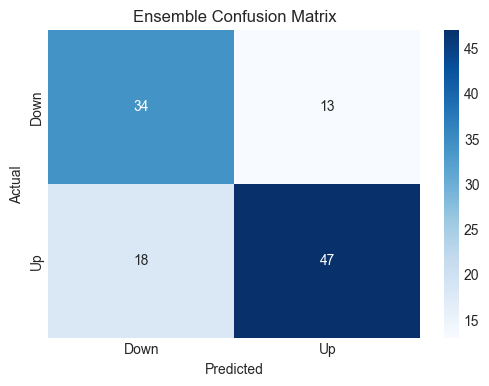

📊 Saved confusion_matrix.png


<Figure size 800x600 with 0 Axes>

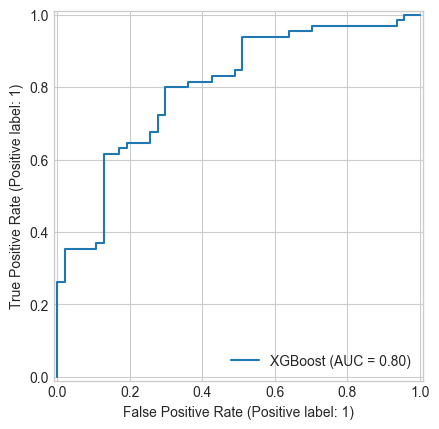

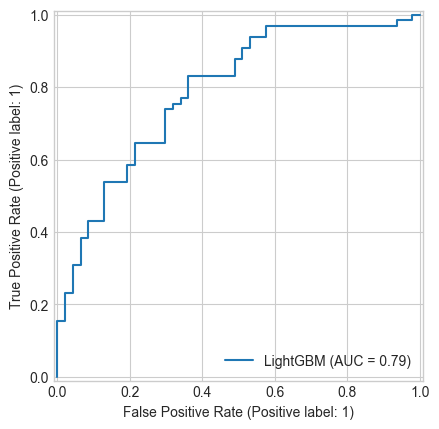

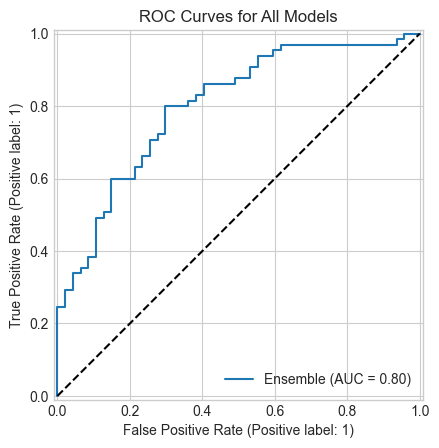

📈 Saved roc_curves.png


In [9]:
# ============================================================
# 9) Save Extended Performance Reports (per-model, per-ticker)
# ============================================================

import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

os.makedirs("../reports", exist_ok=True)
os.makedirs("../results", exist_ok=True)

# ----------------------------------------
# 9.1 Save per-model metrics
# ----------------------------------------
extended_metrics = pd.DataFrame({
    "Metric": ["AUC", "Accuracy"],
    "XGBoost": [
        roc_auc_score(y_test, xgb_test_prob),
        accuracy_score(y_test, (xgb_test_prob > 0.5))
    ],
    "LightGBM": [
        roc_auc_score(y_test, lgb_test_prob),
        accuracy_score(y_test, (lgb_test_prob > 0.5))
    ],
    "Ensemble": [
        roc_auc_score(y_test, ensemble_test_prob),
        accuracy_score(y_test, ensemble_pred)
    ]
})

extended_metrics.to_csv("../reports/extended_model_metrics.csv", index=False)
print("💾 Saved extended_model_metrics.csv")

# ----------------------------------------
# 9.2 Per-ticker metrics (FIXED)
# ----------------------------------------

# Reset positional index for correct alignment
test_df = test_df.reset_index(drop=True)
test_df["pos"] = np.arange(len(test_df))

ticker_metrics = []

for ticker, g in test_df.groupby("Ticker"):
    pos_idx = g["pos"].values

    # Ensemble test probabilities aligned correctly
    proba = ensemble_test_prob[pos_idx]
    pred  = (proba > 0.5).astype(int)
    true  = g[target].values

    auc   = roc_auc_score(true, proba)
    acc   = accuracy_score(true, pred)

    ticker_metrics.append([ticker, auc, acc])

ticker_df = pd.DataFrame(ticker_metrics, columns=["Ticker", "AUC", "Accuracy"])
display(ticker_df)

ticker_df.to_csv("../reports/per_ticker_metrics.csv", index=False)
print(" Saved per_ticker_metrics.csv")


# ----------------------------------------
# 9.3 Confusion Matrix
# ----------------------------------------
cm = confusion_matrix(y_test, ensemble_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down","Up"], yticklabels=["Down","Up"])
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("../results/confusion_matrix.png", dpi=300)
plt.show()

print("📊 Saved confusion_matrix.png")

# ----------------------------------------
# 9.4 ROC Curves
# ----------------------------------------
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(8,6))
RocCurveDisplay.from_predictions(y_test, xgb_test_prob, name="XGBoost")
RocCurveDisplay.from_predictions(y_test, lgb_test_prob, name="LightGBM")
RocCurveDisplay.from_predictions(y_test, ensemble_test_prob, name="Ensemble")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves for All Models")
plt.savefig("../results/roc_curves.png", dpi=300)
plt.show()

print("📈 Saved roc_curves.png")


### Per Ticker Evaluations

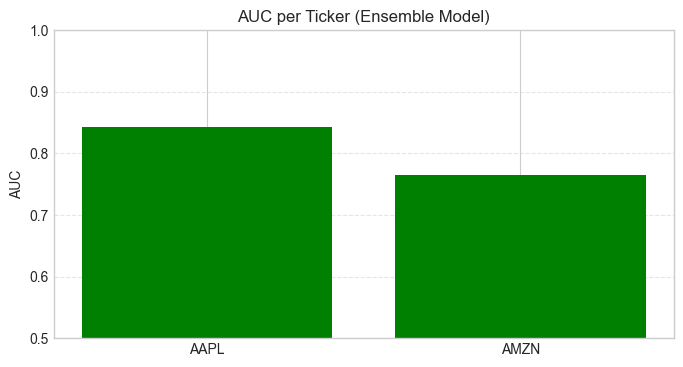

In [10]:
plt.figure(figsize=(8,4))
plt.bar(ticker_df["Ticker"], ticker_df["AUC"], color="green")
plt.title("AUC per Ticker (Ensemble Model)")
plt.ylabel("AUC")
plt.ylim(0.5,1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


### Findings:

Model is better at predicting up moves
47 true positives vs 18 false negatives
which matches:
  - market drifts (stock prices go up more often)
  - sentiment correlation
  - trend-following features (RSI, momentum)

Still good at predicting down movements:
34 correct vs 13 incorrect
Strong given only 112 samples

There is no bias towards predicting only one class which is what the LSTM model struggled with.

### Shap interpretability